<a href="https://colab.research.google.com/github/1ayse/Campaign-A-B-Test-Analysis-using-Python/blob/main/Campaign_A_B_Test_Analysis_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Importing Library Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [4]:
# Upload file to collabs
from google.colab import files
uploaded = files.upload()


Saving marketing.csv to marketing.csv


In [5]:
# Read file
marketing = pd.read_csv('marketing.csv')
marketing.head()

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,01/01/2018,House Ads,personalization,True,English,English,0-18 years,01/01/2018,NaN,House Ads,True
1,a100000030,01/01/2018,House Ads,personalization,True,English,English,19-24 years,01/01/2018,NaN,House Ads,True
2,a100000031,01/01/2018,House Ads,personalization,True,English,English,24-30 years,01/01/2018,NaN,House Ads,True
3,a100000032,01/01/2018,House Ads,personalization,True,English,English,30-36 years,01/01/2018,NaN,House Ads,True
4,a100000033,01/01/2018,House Ads,personalization,True,English,English,36-45 years,01/01/2018,NaN,House Ads,True


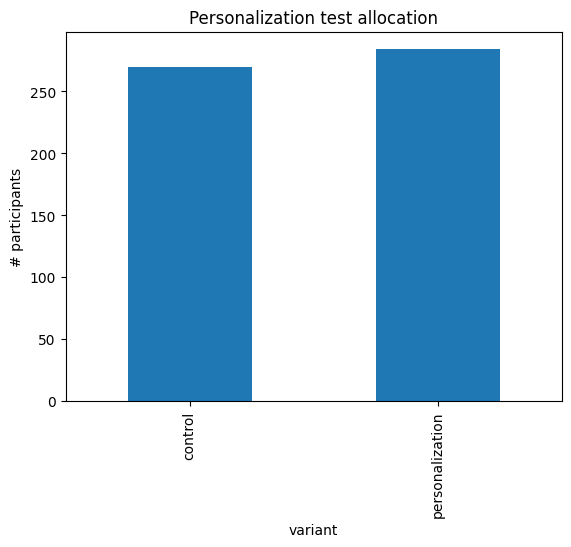

In [6]:
# The email campaign was designed as an A/B test:
  # half received generic upsell emails, while the other half received personalized messages based on site usage.
#Before analyzing the results, we first verify that users were evenly distributed between the test and control groups.


# Subset the DataFrame
email = marketing[marketing['marketing_channel']=='Email']

alloc = email.groupby(['variant'])['user_id'].nunique()

# Plot a bar chart of the test allocation
alloc.plot(kind='bar')
plt.title('Personalization test allocation')
plt.ylabel('# participants')
plt.show()

In [7]:
# Next,we compare conversion rates between the control (generic emails) and personalization (customized emails) groups.
# Since conversion rate is the key metric,
# evaluating whether personalization led to a higher conversion than the control is crucial for assessing A/B test success.

# Group marketing by user_id and variant
subscribers = email.groupby(['user_id',
                             'variant'])['converted'].max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1))

# Drop missing values from the control column
control = subscribers_df['control'].dropna()

# Drop missing values from the personalization column
personalization = subscribers_df['personalization'].dropna()

print('Control conversion rate:', np.mean(control))
print('Personalization conversion rate:', np.mean(personalization))

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


In [8]:
# Calculation of lift and significance

# Lift : Was the conversion rate higher for the treatment and by how much?

# Calculation :
    # (treatment conversion rate - control conversion rate) / control conversion rate

'''Parameters:

    a (Pandas series): pandas series with the conversions of the treatment group

    b (Pandas series): pandas series with the conversions of the control group
'''
def lift(a, b):
    # Calculate the mean of a and b
    a_mean = np.mean(a)
    b_mean = np.mean(b)

    # Calculate the lift using a_mean and b_mean
    lift = (b_mean - a_mean) / a_mean

    return str(round(lift*100, 2)) + '%'

# Print lift() with control and personalization as inputs
print(lift(control, personalization))

38.85%


In [16]:
# We saw that the experiment is highly statistically significant
# Now we identify in which segments it works better and worse

# For this, we are defining an function below

def ab_segmentation(segment):
   for subsegment in np.unique(marketing[segment]):
      print(subsegment)

      # Limit marketing to email and subsegment
      email = marketing[(marketing['marketing_channel'] == "Email") & (marketing[segment] == subsegment)]

      subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
      subscribers = pd.DataFrame(subscribers.unstack(level=1))
      control = subscribers['control'].dropna()
      control = control.astype('int')
      personalization = subscribers['personalization'].dropna()
      personalization = personalization.astype('int')

      print('lift:', lift(personalization, control))
      print('t-statistic:', stats.ttest_ind(control, personalization), '\n\n')

In [17]:
# Apply on language segments
ab_segmentation('language_displayed')

Arabic
lift: -33.33%
t-statistic: TtestResult(statistic=np.float64(-0.5773502691896255), pvalue=np.float64(0.5795840000000001), df=np.float64(8.0)) 


English
lift: -28.06%
t-statistic: TtestResult(statistic=np.float64(-2.2183598646203215), pvalue=np.float64(0.026991701290720503), df=np.float64(486.0)) 


German
lift: 1.65%
t-statistic: TtestResult(statistic=np.float64(0.19100834180787182), pvalue=np.float64(0.8494394170062678), df=np.float64(42.0)) 


Spanish
lift: -62.5%
t-statistic: TtestResult(statistic=np.float64(-2.3570226039551585), pvalue=np.float64(0.040156718110477524), df=np.float64(10.0)) 




/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [18]:
# Apply on age segments
ab_segmentation('age_group')

0-18 years
lift: -54.83%
t-statistic: TtestResult(statistic=np.float64(-2.966044912142212), pvalue=np.float64(0.003872449439129706), df=np.float64(89.0)) 


19-24 years
lift: -51.51%
t-statistic: TtestResult(statistic=np.float64(-3.0317943847866697), pvalue=np.float64(0.0030623836114689195), df=np.float64(105.0)) 


24-30 years
lift: -61.71%
t-statistic: TtestResult(statistic=np.float64(-3.861539544326876), pvalue=np.float64(0.00018743381094867337), df=np.float64(114.0)) 


30-36 years
lift: inf%
t-statistic: TtestResult(statistic=np.float64(3.185906464414798), pvalue=np.float64(0.0023238487431765337), df=np.float64(58.0)) 


36-45 years
lift: 576.92%
t-statistic: TtestResult(statistic=np.float64(2.431790127931851), pvalue=np.float64(0.01797568600978825), df=np.float64(61.0)) 


45-55 years
lift: 260.0%
t-statistic: TtestResult(statistic=np.float64(2.0654991273179326), pvalue=np.float64(0.04306233968820123), df=np.float64(62.0)) 


55+ years
lift: inf%
t-statistic: TtestResult(statisti

/tmp/ipython-input-1721683755.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  lift = (b_mean - a_mean) / a_mean
/tmp/ipython-input-1721683755.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  lift = (b_mean - a_mean) / a_mean


In [ ]:
'''
# Conclusion #
The experiment was statically significant

by segments
------------
Language:
he test was successful for English and Spanish speakers, while results for other languages were not statistically significant,
highlighting the importance of monitoring differences across groups.

Age Group:
Personalization was highly effective for younger users but less effective for older users,
possibly because younger users appreciate personalized insights, while older users may perceive it as a privacy concern.